In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import json
import pickle

In [2]:
SAMPLE_USERS = 10000
NEG_RATIO = 1.0

In [3]:
def prepare_content_features(books_data, all_items):
    """
    Подготовка контентных признаков для книг
    """
    books_data = books_data.copy()
    
    # Заполняем пропущенные значения
    books_data['authors'] = books_data['authors'].fillna('Unknown')
    books_data['original_title'] = books_data['original_title'].fillna('')
    books_data['title'] = books_data['title'].fillna('')
    books_data['language_code'] = books_data['language_code'].fillna('unknown')
    books_data['original_publication_year'] = books_data['original_publication_year'].fillna(
        books_data['original_publication_year'].median()
    )
    books_data['average_rating'] = books_data['average_rating'].fillna(
        books_data['average_rating'].median()
    )
    
    # Создаем текстовые признаки
    books_data['text_features'] = (
        books_data['authors'] + ' ' + 
        books_data['original_title'] + ' ' + 
        books_data['title'] + ' ' + 
        books_data['language_code']
    )
    
    # TF-IDF для текстовых признаков
    tfidf = TfidfVectorizer(max_features=100, stop_words='english', min_df=2)
    tfidf_features = tfidf.fit_transform(books_data['text_features'])
    
    # Числовые признаки
    numeric_features = books_data[['original_publication_year', 'average_rating']].values
    
    # Масштабируем числовые признаки
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(numeric_features)
    
    # One-hot encoding для language_code
    language_encoded = pd.get_dummies(books_data['language_code'], prefix='lang')
    
    # Объединяем все признаки
    content_features = csr_matrix(
        np.hstack([
            tfidf_features.toarray(),
            numeric_features_scaled,
            language_encoded.values
        ])
    )
    
    # Создаем маппинг book_id -> features
    features_dict = {}
    for idx, item_id in enumerate(books_data['item_id']):
        features_dict[str(item_id)] = content_features[idx]
    
    # Добавляем нулевые признаки для книг, которых нет в books_data
    for item in all_items:
        if item not in features_dict:
            features_dict[item] = csr_matrix((1, content_features.shape[1]))
    
    return features_dict

In [4]:
def compute_content_similarity(content_features, item_to_idx):
    """
    Вычисление матрицы схожести по контентным признакам
    """
    items_list = list(item_to_idx.keys())
    
    # Создаем матрицу признаков для всех items
    feature_matrix = []
    valid_items = []
    
    for item in items_list:
        if item in content_features:
            feature_matrix.append(content_features[item].toarray().flatten())
            valid_items.append(item)
    
    if not feature_matrix:
        return {}
    
    feature_matrix = np.array(feature_matrix)
    
    # Вычисляем косинусную схожесть
    similarity_matrix = cosine_similarity(feature_matrix)
    
    # Создаем словарь схожестей
    similarity_dict = {}
    for i, item1 in enumerate(valid_items):
        similarity_dict[item1] = {}
        for j, item2 in enumerate(valid_items):
            if i != j:
                similarity_dict[item1][item2] = similarity_matrix[i, j]
    
    return similarity_dict

In [5]:
def combine_recommendations(als_rec_dict, user_history, content_similarity, 
                          content_weight=0.3, k=10):
    """
    Комбинирование ALS рекомендаций с контентными
    """
    if not user_history or content_weight == 0:
        # Если нет истории или нулевой вес контента, возвращаем чистые ALS рекомендации
        return list(als_rec_dict.keys())[:k]
    
    # Нормализуем ALS scores
    als_scores = np.array(list(als_rec_dict.values()))
    if len(als_scores) > 0:
        als_scores = (als_scores - als_scores.min()) / (als_scores.max() - als_scores.min() + 1e-8)
    
    als_items = list(als_rec_dict.keys())
    combined_scores = {}
    
    # Вычисляем контентные скоры на основе истории пользователя
    for i, item in enumerate(als_items):
        content_score = 0.0
        count = 0
        
        for hist_item in user_history:
            if (hist_item in content_similarity and 
                item in content_similarity[hist_item]):
                content_score += content_similarity[hist_item][item]
                count += 1
        
        if count > 0:
            content_score /= count
        
        # Комбинируем скоры
        als_score = als_scores[i] if i < len(als_scores) else 0
        combined_score = (1 - content_weight) * als_score + content_weight * content_score
        combined_scores[item] = combined_score
    
    # Сортируем по комбинированному скору
    sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [item for item, score in sorted_items[:k]]

In [6]:
def make_hybrid_content_recommender(train_df, books_data, k=10, factors=32, reg=0.1, iters=15, 
                                  content_weight=0.3, seed=42):
    """
    Гибридная рекомендательная система, комбинирующая ALS и контентные признаки
    """
    # Подготовка данных
    users = train_df["user_id"].unique()
    items = train_df["item_id"].unique()
    
    # Фильтруем books_data только по существующим книгам
    books_data = books_data[books_data['item_id'].isin(items)].copy()
    
    # Создаем маппинги
    user_to_idx = {u: i for i, u in enumerate(users)}
    item_to_idx = {item: i for i, item in enumerate(items)}
    idx_to_item = {i: item for item, i in item_to_idx.items()}
    
    # Строим ALS модель
    row = train_df["user_id"].map(user_to_idx)
    col = train_df["item_id"].map(item_to_idx)
    data_vals = train_df["rating"]
    user_item_csr = csr_matrix((data_vals, (row, col)), shape=(len(users), len(items)))
    
    model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iters, random_state=seed)
    model.fit(user_item_csr)
    
    # Подготовка контентных признаков
    content_features = prepare_content_features(books_data, items)
    content_similarity = compute_content_similarity(content_features, item_to_idx)
    
    def recommend(users_list):
        recs = {}
        for u in users_list:
            if u not in user_to_idx:
                # Если пользователь новый - возвращаем популярные книги
                recs[u] = train_df["item_id"].value_counts().index[:k].tolist()
                continue
            
            uid = user_to_idx[u]
            
            # Получаем рекомендации от ALS
            als_recommended, als_scores = model.recommend(
                uid, user_item_csr[uid], N=k*3, filter_already_liked_items=True
            )
            
            # Преобразуем в словарь {item_id: score}
            als_rec_dict = {idx_to_item[idx]: score for idx, score in zip(als_recommended, als_scores)}
            
            # Получаем историю пользователя для контентных рекомендаций
            user_history = train_df[(train_df["user_id"] == u) & (train_df["rating"] > 0)]["item_id"].tolist()
            
            # Комбинируем рекомендации
            final_scores = combine_recommendations(
                als_rec_dict, user_history, content_similarity, 
                content_weight=content_weight, k=k
            )
            
            recs[u] = final_scores
        
        return recs
    
    return recommend

In [7]:
# Загрузка данных о рейтингах
ratings = pd.read_parquet('../data/ratings.parquet', engine='pyarrow')
ratings = ratings.rename(columns={'book_id': 'item_id'})
ratings["user_id"] = ratings["user_id"].astype(str)
ratings["item_id"] = ratings["item_id"].astype(str)
ratings["rating"] = ratings["rating"].astype(int)

# Если в данных нет timestamp, добавляем его
if "timestamp" not in ratings.columns:
    start_date = datetime(2021,1,1)
    ratings["timestamp"] = [start_date + timedelta(days=random.randint(0, 365*2)) for _ in range(len(ratings))]
else:
    ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], errors="coerce")
    mask = ratings["timestamp"].isna()
    if mask.any():
        start_date = datetime(2021,1,1)
        ratings.loc[mask, "timestamp"] = [start_date + timedelta(days=random.randint(0, 365*2)) for _ in range(mask.sum())]

In [8]:
print("Уникальные пользователи в ratings:", ratings["user_id"].nunique())
print("Уникальные айтемы в ratings:", ratings["item_id"].nunique())
print("Первые строки ratings:")
print(ratings.head())

Уникальные пользователи в ratings: 53424
Уникальные айтемы в ratings: 10000
Первые строки ratings:
  user_id item_id  rating  timestamp
0       1     258       5 2022-01-17
1       2    4081       4 2022-03-15
2       2     260       5 2022-08-10
3       2    9296       5 2022-06-29
4       2    2318       3 2021-04-27


In [9]:
# Загрузка данных о книгах
books_main_data = pd.read_parquet('../data/books_main_data.parquet', engine='pyarrow')
books_main_data = books_main_data.rename(columns={'book_id': 'item_id'})
books_main_data["item_id"] = books_main_data["item_id"].astype(str)

In [10]:
print("Уникальные книги в books_main_data:", books_main_data["item_id"].nunique())
print("Первые строки books_main_data:")
print(books_main_data.head())

Уникальные книги в books_main_data: 10000
Первые строки books_main_data:
  item_id                      authors  original_publication_year  \
0       1              Suzanne Collins                     2008.0   
1       2  J.K. Rowling, Mary GrandPré                     1997.0   
2       3              Stephenie Meyer                     2005.0   
3       4                   Harper Lee                     1960.0   
4       5          F. Scott Fitzgerald                     1925.0   

                             original_title  \
0                          The Hunger Games   
1  Harry Potter and the Philosopher's Stone   
2                                  Twilight   
3                     To Kill a Mockingbird   
4                          The Great Gatsby   

                                               title language_code  \
0            The Hunger Games (The Hunger Games, #1)           eng   
1  Harry Potter and the Sorcerer's Stone (Harry P...           eng   
2                  

In [11]:
# Проверяем пересечение книг между ratings и books_main_data
common_books = set(ratings["item_id"]).intersection(set(books_main_data["item_id"]))
print(f"Общие книги между ratings и books_main_data: {len(common_books)}")

Общие книги между ratings и books_main_data: 10000


In [12]:
def temporal_split(df, test_size=0.2):
    train, test = [], []
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id].sort_values('timestamp')
        split_idx = int(len(user_data) * (1 - test_size))
        train.append(user_data.iloc[:split_idx])
        test.append(user_data.iloc[split_idx:])
    return pd.concat(train), pd.concat(test)

In [13]:
# Сэмплируем пользователей для ускорения вычислений (используем ваш подход)
sample_users = np.random.choice(ratings["user_id"].unique(), size=min(SAMPLE_USERS, len(ratings["user_id"].unique())), replace=False)
ratings_sampled = ratings[ratings["user_id"].isin(sample_users)].reset_index(drop=True)
print(f"После сэмплирования: {len(ratings_sampled)} записей от {len(sample_users)} пользователей")

После сэмплирования: 1118058 записей от 10000 пользователей


In [14]:
train_data, test_data = temporal_split(ratings_sampled, test_size=0.2)

In [15]:
def add_negative_samples(df, all_items, negative_ratio=1.0, seed=42):
    rng = np.random.default_rng(seed)
    rows = []
    for u, grp in df.groupby("user_id"):
        pos_items = set(grp[grp["rating"] > 0]["item_id"])
        n_neg = int(len(pos_items) * negative_ratio)
        if n_neg > 0:
            neg_items = rng.choice(list(set(all_items) - pos_items), size=n_neg, replace=False)
            for i in neg_items:
                rows.append({"user_id": u, "item_id": i, "rating": 0})
    neg_df = pd.DataFrame(rows)
    return pd.concat([df, neg_df]).reset_index(drop=True)

In [16]:
# Получаем все уникальные предметы для негативных сэмплов
all_items = ratings_sampled["item_id"].unique()

# Добавляем негативные сэмплы к тренировочным и тестовым данным
train_data_ns = add_negative_samples(train_data, all_items, negative_ratio=NEG_RATIO)
test_data_ns = add_negative_samples(test_data, all_items, negative_ratio=NEG_RATIO)

print(f"После добавления негативных сэмплов:")
print(f"Train data: {len(train_data_ns)} записей")
print(f"Test data: {len(test_data_ns)} записей")

После добавления негативных сэмплов:
Train data: 1780892 записей
Test data: 455224 записей


In [17]:
# Пользователи для оценки
eval_users = test_data_ns["user_id"].unique()
print(f"Пользователей для оценки: {len(eval_users)}")

Пользователей для оценки: 10000


In [19]:
K = 10
rec_hybrid = make_hybrid_content_recommender(
    train_data_ns, 
    books_main_data, 
    k=K, 
    factors=32, 
    reg=0.1, 
    iters=15,
    content_weight=0.3,
    seed=7
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [20]:
def ndcg_at_k(r, k):
    r = np.array(r)[:k]
    dcg = np.sum((2**r - 1) / np.log2(np.arange(2, len(r) + 2)))
    ideal_r = np.sort(r)[::-1]
    idcg = np.sum((2**ideal_r - 1) / np.log2(np.arange(2, len(ideal_r) + 2)))
    return dcg / idcg if idcg > 0 else 0.0

def apk(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

In [21]:
def evaluate_bootstrap(recommender, test_df, users, k=10, n_boot=20, seed=42):
    rng = np.random.default_rng(seed)
    scores_ndcg, scores_map = [], []
    for _ in range(n_boot):
        sampled_users = rng.choice(users, size=min(len(users), 500), replace=True)
        recs = recommender(sampled_users)
        ndcgs, maps = [], []
        for u in sampled_users:
            actual_items = test_df[(test_df["user_id"]==u) & (test_df["rating"]>0)]["item_id"].tolist()
            predicted = recs[u]
            r = [1 if i in actual_items else 0 for i in predicted]
            ndcgs.append(ndcg_at_k(r, k))
            maps.append(apk(actual_items, predicted, k))
        scores_ndcg.append(np.mean(ndcgs))
        scores_map.append(np.mean(maps))
    return {
        "ndcg_mean": np.mean(scores_ndcg),
        "ndcg_std": np.std(scores_ndcg),
        "map_mean": np.mean(scores_map),
        "map_std": np.std(scores_map),
        "n_boot": n_boot
    }

def print_results(name, res):
    print(f"{name}: nDCG@{K} = {res['ndcg_mean']:.4f} ± {res['ndcg_std']:.4f}, "
          f"MAP@{K} = {res['map_mean']:.4f} ± {res['map_std']:.4f} (n_boot={res['n_boot']})")

In [22]:
K_metr = 10
N_BOOT = 20
ALPHA_DECAY = 0.01
TIME_WINDOW = 30
print("Оценка гибридной модели...")
res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
print_results("Hybrid ALS+Content", res_hybrid)

Оценка гибридной модели...
Hybrid ALS+Content: nDCG@10 = 0.6427 ± 0.0112, MAP@10 = 0.1792 ± 0.0039 (n_boot=20)


In [23]:
def make_random_recommender(items, k=10, seed=42):
    rng = np.random.default_rng(seed)
    return lambda users: {u: rng.choice(items, size=k, replace=False).tolist() for u in users}

def make_popular_recommender(train_df, k=10):
    top_items = train_df[train_df["rating"]>0]["item_id"].value_counts().index[:k].tolist()
    return lambda users: {u: top_items for u in users}

def make_popular_time_recommender(train_df, k=10, alpha=0.01):
    now = train_df["timestamp"].max()
    train_df["weight"] = train_df["rating"] * np.exp(-alpha * (now - train_df["timestamp"]).dt.days)
    top_items = train_df.groupby("item_id")["weight"].sum().sort_values(ascending=False).index[:k].tolist()
    return lambda users: {u: top_items for u in users}

def make_als_recommender(train_df, k=10, factors=32, reg=0.1, iters=15, seed=42):
    users = train_df["user_id"].unique()
    items = train_df["item_id"].unique()
    user_to_idx = {u:i for i,u in enumerate(users)}
    idx_to_item = {i:u for u,i in enumerate({item:i for i,item in enumerate(items)})}

    row = train_df["user_id"].map(user_to_idx)
    col = train_df["item_id"].map({i:j for j,i in enumerate(items)})
    data_vals = train_df["rating"]
    user_item_csr = csr_matrix((data_vals, (row, col)), shape=(len(users), len(items)))

    model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iters, random_state=seed)
    model.fit(user_item_csr)

    def recommend(users_list):
        recs = {}
        for u in users_list:
            if u not in user_to_idx:
                recs[u] = train_df["item_id"].value_counts().index[:k].tolist()
                continue
            uid = user_to_idx[u]
            recommended, scores = model.recommend(uid, user_item_csr[uid], N=k, filter_already_liked_items=True)
            recs[u] = [items[i] for i in recommended]
        return recs
    return recommend

In [26]:
hybrid_dict_first = {}
random_dict = {}
popular_dict = {}
dry_als_dict = {}
Ks = [5, 10, 15, 25, 50, 100, 150, 250]
for K_metr in Ks:
    rec_hybrid = make_hybrid_content_recommender(train_data_ns, books_main_data, k=K_metr, factors=32, reg=0.1, iters=15, content_weight=0.3, seed=7)
    res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    hybrid_dict_first[K_metr] = res_hybrid

    rec_als = make_als_recommender(train_data_ns, k=K_metr, factors=32, reg=0.1, iters=15, seed=7)
    res_als = evaluate_bootstrap(rec_als, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    dry_als_dict[K_metr] = res_als

    rec_pop = make_popular_recommender(train_data_ns, k=K_metr)
    res_pop = evaluate_bootstrap(rec_pop, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    popular_dict[K_metr] = res_pop

    rec_random = make_random_recommender(all_items, k=K_metr)
    res_random = evaluate_bootstrap(rec_random, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    random_dict[K_metr] = res_random

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
hybrid_dict_first

{5: {'ndcg_mean': 0.6250646464469749,
  'ndcg_std': 0.01418555725135783,
  'map_mean': 0.26061666666666666,
  'map_std': 0.006562685595259163,
  'n_boot': 20},
 10: {'ndcg_mean': 0.6426917729260485,
  'ndcg_std': 0.011218346045640724,
  'map_mean': 0.17919033780549254,
  'map_std': 0.0038627152453812154,
  'n_boot': 20},
 15: {'ndcg_mean': 0.6413250485462633,
  'ndcg_std': 0.009056014361688089,
  'map_mean': 0.1398519222258144,
  'map_std': 0.0035791291720185755,
  'n_boot': 20},
 25: {'ndcg_mean': 0.6343596350133117,
  'ndcg_std': 0.007898344054344175,
  'map_mean': 0.11072480718280646,
  'map_std': 0.0027856449585316515,
  'n_boot': 20},
 50: {'ndcg_mean': 0.620964690378859,
  'ndcg_std': 0.006572483868540911,
  'map_mean': 0.12299987620888894,
  'map_std': 0.0029151722696165645,
  'n_boot': 20},
 100: {'ndcg_mean': 0.6043829634872986,
  'ndcg_std': 0.005539876729746973,
  'map_mean': 0.13636047925662614,
  'map_std': 0.0031818330889041243,
  'n_boot': 20},
 150: {'ndcg_mean': 0.5958

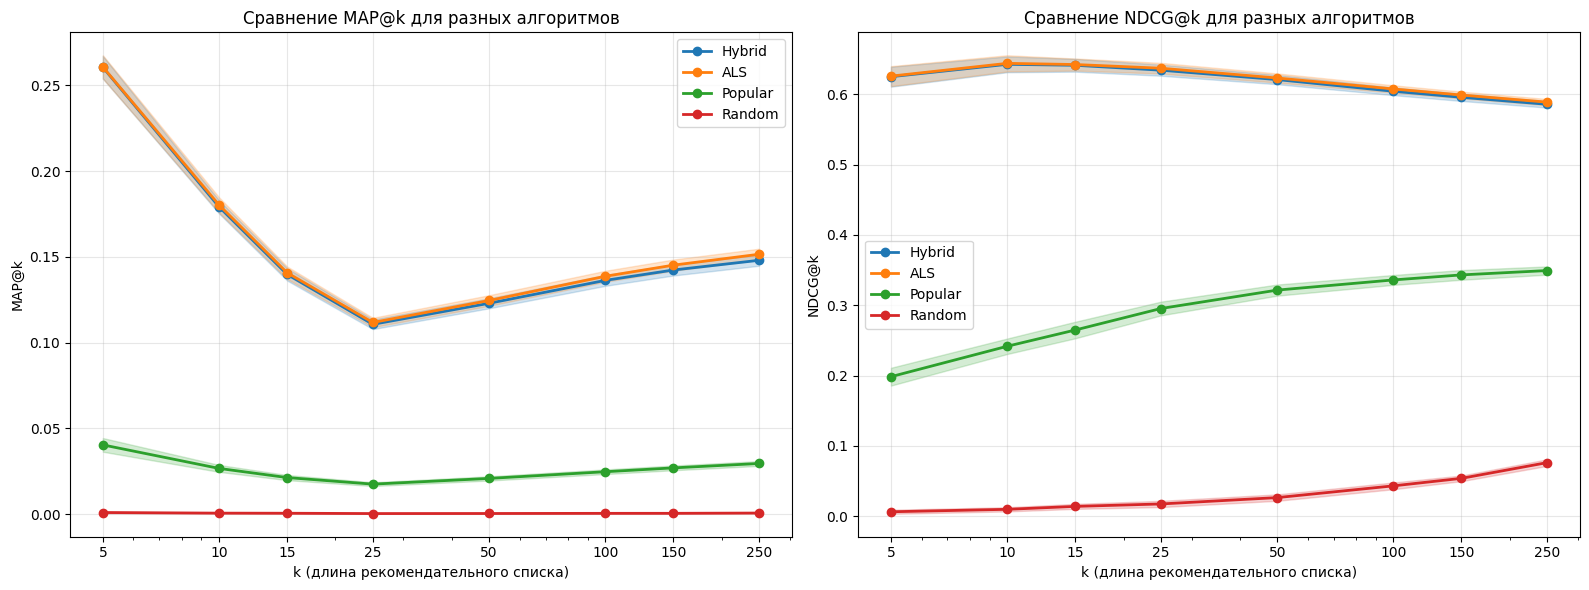

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для построения графиков
def plot_metrics_comparison(metrics_dict, metric_name, title, ax):
    """
    metrics_dict: словарь с алгоритмами и их метриками
    metric_name: 'map' или 'ndcg'
    title: заголовок графика
    ax: ось для построения
    """
    Ks = [5, 10, 15, 25, 50, 100, 150, 250]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Цвета для алгоритмов
    algorithms = ['Hybrid', 'ALS', 'Popular', 'Random']
    dicts = [hybrid_dict_first, dry_als_dict, popular_dict, random_dict]
    
    for i, (algo, algo_dict, color) in enumerate(zip(algorithms, dicts, colors)):
        means = []
        stds = []
        
        for k in Ks:
            mean_key = f'{metric_name}_mean'
            std_key = f'{metric_name}_std'
            means.append(algo_dict[k][mean_key])
            stds.append(algo_dict[k][std_key])
        
        # Основная линия
        ax.plot(Ks, means, 'o-', color=color, linewidth=2, markersize=6, label=algo)
        
        # Область стандартного отклонения
        ax.fill_between(Ks, 
                       np.array(means) - np.array(stds), 
                       np.array(means) + np.array(stds), 
                       alpha=0.2, color=color)
    
    ax.set_xlabel('k (длина рекомендательного списка)')
    ax.set_ylabel(f'{metric_name.upper()}@k')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Логарифмическая шкала для оси x для лучшей читаемости
    ax.set_xscale('log')
    ax.set_xticks(Ks)
    ax.set_xticklabels(Ks)

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График для MAP
plot_metrics_comparison({
    'Hybrid': hybrid_dict_first,
    'ALS': dry_als_dict,
    'Popular': popular_dict,
    'Random': random_dict
}, 'map', 'Сравнение MAP@k для разных алгоритмов', ax1)

# График для NDCG
plot_metrics_comparison({
    'Hybrid': hybrid_dict_first,
    'ALS': dry_als_dict,
    'Popular': popular_dict,
    'Random': random_dict
}, 'ndcg', 'Сравнение NDCG@k для разных алгоритмов', ax2)

plt.tight_layout()
plt.show()

In [36]:
config1 = {
    'factors': 32,
    'reg': 0.1,
    'iters': 15,
    'content_weight': 0.3,
    'max_features': 100,
    'min_df': 2,
    'als_candidates': 30  # k*3 при k=10
}
config2 = {
    'factors': 64,
    'reg': 0.05,
    'iters': 20,
    'content_weight': 0.5,  # Больше вес контента
    'max_features': 200,    # Больше текстовых признаков
    'min_df': 1,           # Включаем редкие термины
    'als_candidates': 40
}
config3 = {
    'factors': 48,
    'reg': 0.15,
    'iters': 25,
    'content_weight': 0.2,  # Меньше вес контента
    'max_features': 150,
    'min_df': 3,           # Только частые термины
    'als_candidates': 30
}
config4 = {
    'factors': 32,
    'reg': 0.1,
    'iters': 15,
    'content_weight': 0.7,  # Сильный акцент на контент
    'max_features': 100,
    'min_df': 2,
    'als_candidates': 50    # Больше кандидатов для отбора
}

In [38]:
hybrid_dict_1 = {}
hybrid_dict_2 = {}
hybrid_dict_3 = {}
hybrid_dict_4 = {}
Ks = [5, 10, 15, 25, 50, 100, 150, 250]
for K_metr in Ks:
    rec_hybrid = make_hybrid_content_recommender(train_data_ns, books_main_data, k=K_metr, factors=config1['factors'], reg=config1['reg'], iters=config1['iters'], content_weight=config1['content_weight'], seed=7)
    res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    hybrid_dict_1[K_metr] = res_hybrid

    rec_hybrid = make_hybrid_content_recommender(train_data_ns, books_main_data, k=K_metr, factors=config2['factors'], reg=config2['reg'], iters=config2['iters'], content_weight=config2['content_weight'], seed=7)
    res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    hybrid_dict_2[K_metr] = res_hybrid

    rec_hybrid = make_hybrid_content_recommender(train_data_ns, books_main_data, k=K_metr, factors=config3['factors'], reg=config3['reg'], iters=config3['iters'], content_weight=config3['content_weight'], seed=7)
    res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    hybrid_dict_3[K_metr] = res_hybrid

    rec_hybrid = make_hybrid_content_recommender(train_data_ns, books_main_data, k=K_metr, factors=config4['factors'], reg=config4['reg'], iters=config4['iters'], content_weight=config4['content_weight'], seed=7)
    res_hybrid = evaluate_bootstrap(rec_hybrid, test_data_ns, eval_users, k=K_metr, n_boot=N_BOOT)
    hybrid_dict_4[K_metr] = res_hybrid

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

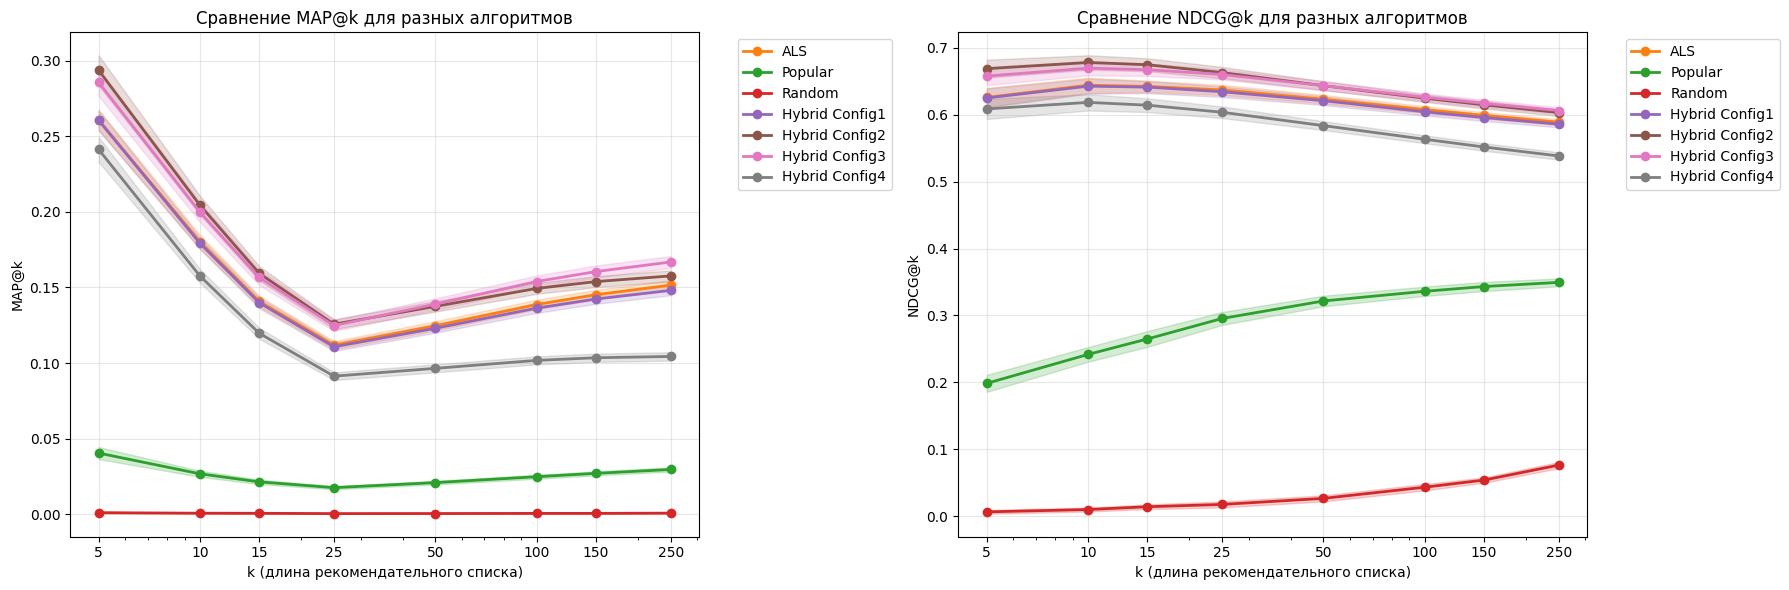

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для построения графиков
def plot_metrics_comparison(metrics_dict, metric_name, title, ax):
    """
    metrics_dict: словарь с алгоритмами и их метриками
    metric_name: 'map' или 'ndcg'
    title: заголовок графика
    ax: ось для построения
    """
    Ks = [5, 10, 15, 25, 50, 100, 150, 250]
    
    # Цвета для алгоритмов - старые + новые гибридные
    colors = ['#ff7f0e', '#2ca02c', '#d62728',  # Старые алгоритмы
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  # Новые гибридные
    
    algorithms = ['ALS', 'Popular', 'Random', 
                  'Hybrid Config1', 'Hybrid Config2', 'Hybrid Config3', 'Hybrid Config4']
    
    dicts = [dry_als_dict, popular_dict, random_dict,
             hybrid_dict_1, hybrid_dict_2, hybrid_dict_3, hybrid_dict_4]
    
    for i, (algo, algo_dict, color) in enumerate(zip(algorithms, dicts, colors)):
        means = []
        stds = []
        
        for k in Ks:
            mean_key = f'{metric_name}_mean'
            std_key = f'{metric_name}_std'
            means.append(algo_dict[k][mean_key])
            stds.append(algo_dict[k][std_key])
        
        # Основная линия
        ax.plot(Ks, means, 'o-', color=color, linewidth=2, markersize=6, label=algo)
        
        # Область стандартного отклонения
        ax.fill_between(Ks, 
                       np.array(means) - np.array(stds), 
                       np.array(means) + np.array(stds), 
                       alpha=0.2, color=color)
    
    ax.set_xlabel('k (длина рекомендательного списка)')
    ax.set_ylabel(f'{metric_name.upper()}@k')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа
    ax.grid(True, alpha=0.3)
    
    # Логарифмическая шкала для оси x для лучшей читаемости
    ax.set_xscale('log')
    ax.set_xticks(Ks)
    ax.set_xticklabels(Ks)

# Создаем фигуру с двумя подграфиками (увеличиваем ширину для легенды)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# График для MAP
plot_metrics_comparison({
    'Hybrid': hybrid_dict_first,
    'ALS': dry_als_dict,
    'Popular': popular_dict,
    'Random': random_dict,
    'Hybrid Config1': hybrid_dict_1,
    'Hybrid Config2': hybrid_dict_2,
    'Hybrid Config3': hybrid_dict_3,
    'Hybrid Config4': hybrid_dict_4
}, 'map', 'Сравнение MAP@k для разных алгоритмов', ax1)

# График для NDCG
plot_metrics_comparison({
    'Hybrid': hybrid_dict_first,
    'ALS': dry_als_dict,
    'Popular': popular_dict,
    'Random': random_dict,
    'Hybrid Config1': hybrid_dict_1,
    'Hybrid Config2': hybrid_dict_2,
    'Hybrid Config3': hybrid_dict_3,
    'Hybrid Config4': hybrid_dict_4
}, 'ndcg', 'Сравнение NDCG@k для разных алгоритмов', ax2)

plt.tight_layout()
plt.show()

In [41]:
import json
import pickle

# Сохранение всех словарей в один JSON файл
data_to_save = {
    'hybrid_dict_first': hybrid_dict_first,
    'dry_als_dict': dry_als_dict,
    'popular_dict': popular_dict,
    'random_dict': random_dict,
    'hybrid_dict_1': hybrid_dict_1,
    'hybrid_dict_2': hybrid_dict_2,
    'hybrid_dict_3': hybrid_dict_3,
    'hybrid_dict_4': hybrid_dict_4
}

# Сохранение
with open('recsys_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(data_to_save, f, indent=2, ensure_ascii=False)

print("Словари сохранены в recsys_metrics.json")

Словари сохранены в recsys_metrics.json
